<a href="https://colab.research.google.com/github/nandhukumar86/AIML-Practice/blob/master/MobileNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import skimage.io as io
import os
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, Concatenate, Reshape, UpSampling2D
import pickle
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.losses import binary_crossentropy

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications import VGG16

In [2]:
file = open('/content/drive/MyDrive/CapstoneDataSet/dataset/RezisedLabel-1.pickle', 'rb')
dfData = pickle.load(file)
file.close()

In [3]:
dfData.head()

,patientId,x,y,width,height,Target,X,Y,Image256,Xo,Yo,xo,yo,widtho,heighto,Age,Sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1024,1024,"[[92, 50, 30, 17, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4...",256,256,NaN,NaN,NaN,NaN,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1024,1024,"[[20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",256,256,NaN,NaN,NaN,NaN,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1024,1024,"[[18, 16, 15, 15, 14, 14, 13, 14, 14, 14, 14, ...",256,256,NaN,NaN,NaN,NaN,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1024,1024,"[[205, 202, 193, 192, 187, 185, 180, 179, 177,...",256,256,NaN,NaN,NaN,NaN,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,1024,1024,"[[2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 4, 4, 5,...",256,256,66.0,38.0,54.0,95.0,32,F


In [4]:
from google.colab.patches import cv2_imshow

In [34]:
from tensorflow import reduce_sum
from tensorflow.keras.backend import log,epsilon

def dice_coefficient(y_true, y_pred):
  numerator = 2 * reduce_sum(y_true * y_pred)
  denominator = reduce_sum(y_true + y_pred)

  return numerator / (denominator + epsilon())


def loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [59]:
y_train = []
X_train = []
i = 0
for pId in dfData['patientId'].unique():
  data = dfData[dfData['patientId'] == pId][['Image256','xo','yo','widtho','heighto','Target']]
  X_train.append(cv2.cvtColor(cv2.resize(data.iloc[0][0],(256,256)), cv2.COLOR_BAYER_GR2RGB))
  mask = np.zeros((256,256))
  if (data.iloc[0][5] == 1):
    j = 0
    for segment in range(data.shape[0]):
      xo = int(data.iloc[j][1])
      yo = int(data.iloc[j][2])
      wo = int(data.iloc[j][1] + data.iloc[j][3])
      ho = int(data.iloc[j][2] + data.iloc[j][4])
      mask = cv2.rectangle(mask,(xo, yo),(wo, ho),(255,0,0),-1)
      mask = cv2.resize(mask,(256,256))
      j = j+1
  y_train.append(cv2.resize(mask,(32,32)))
  if (i%1000 == 0):
    print(i, " completed")
  if (i==1999):
    break;
  i = i + 1

0  completed
1000  completed


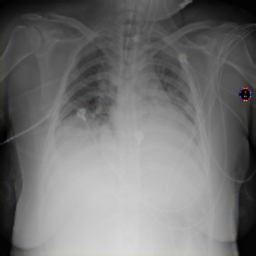

(256, 256, 3)
(32, 32)


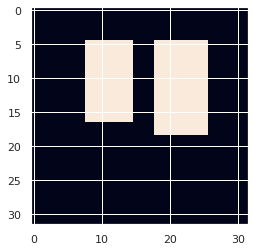

In [61]:
n = 4
cv2_imshow(X_train[n]);
plt.imshow(y_train[n]);
print(X_train[n].shape)
print(y_train[n].shape)


In [62]:
X_train_1 = preprocess_input(np.array(X_train))
y_train_1 = np.array(y_train)/255

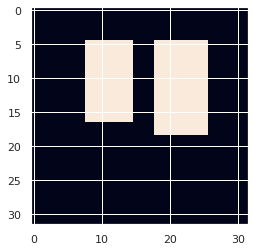

In [63]:
plt.imshow(y_train_1[4]);

In [79]:
tensorflow.keras.backend.clear_session()

In [80]:
model = MobileNet(input_shape=(256,256,3),include_top=False,alpha=1,weights='imagenet')

for l in model.layers:
  l.trainable = False;

layer8x8 = model.get_layer('conv_pw_13_relu').output
layer16x16 = model.get_layer('conv_pw_11_relu').output
layer32x32 = model.get_layer('conv_pw_5_relu').output

x = Concatenate()([UpSampling2D()(layer8x8),layer16x16])
x = Concatenate()([UpSampling2D()(x),layer32x32])

x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

model = Model(model.input, x)

model.compile(optimizer='adam', loss=loss, metrics=[dice_coefficient])

model.fit(X_train_1, y_train_1, epochs=50, batch_size=32, verbose=1) 

Epoch 1/50
63/63 [==============================] - 4s 39ms/step - loss: 1.7342 - dice_coefficient: 0.2377
Epoch 2/50
63/63 [==============================] - 2s 39ms/step - loss: 1.1503 - dice_coefficient: 0.3703
Epoch 3/50
63/63 [==============================] - 2s 39ms/step - loss: 1.0516 - dice_coefficient: 0.4071
Epoch 4/50
63/63 [==============================] - 2s 39ms/step - loss: 1.0117 - dice_coefficient: 0.4238
Epoch 5/50
63/63 [==============================] - 2s 39ms/step - loss: 0.9707 - dice_coefficient: 0.4403
Epoch 6/50
63/63 [==============================] - 2s 39ms/step - loss: 0.9411 - dice_coefficient: 0.4536
Epoch 7/50
63/63 [==============================] - 2s 39ms/step - loss: 0.9319 - dice_coefficient: 0.4569
Epoch 8/50
63/63 [==============================] - 2s 39ms/step - loss: 0.9426 - dice_coefficient: 0.4580
Epoch 9/50
63/63 [==============================] - 2s 38ms/step - loss: 0.9018 - dice_coefficient: 0.4705
Epoch 10/50
63/63 [==================

In [81]:
# y_test_predict = model.predict(X_test)
y_train_predict = model.predict(X_train_1)


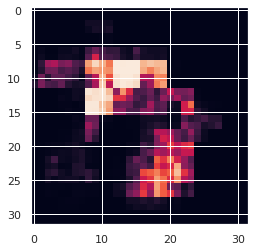

In [91]:
plt.imshow(y_train_predict[86].reshape(32,32))

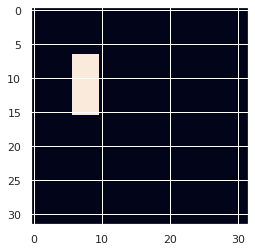

In [92]:
plt.imshow(y_train_1[86]);